In [50]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

<figure id="figure-3">
<div style="background-color: white">

![](figures/dct.svg)</div>
    
<figcaption style="text-align: center">Figure 3: A DCT can be treated as an N channel filter bank where the coefficients of the
filters are the basis functions.</figcaption></figure>

# 7 The Discrete Cosine Transform (DCT)


The DCT is a method of performing energy compaction that is rather different
from the pyramid method.  It operates on non-overlapping blocks of pixels
(typically $8 \times 8$ pixels in size) by a reversible linear transform
process, such that each block of pixels is replaced by a block of the same
number of transform coefficients.  If all the transform coefficients for a
given block are transmitted unaltered to the decoder, then the original block
of pixels can be exactly recovered by the inverse transform process.

In practise the transform coefficients are quantised before transmission, and
if energy compaction has occurred, then fewer bits will be needed to send the
coefficients than the original pixels.  A key advantage of transform-based
methods is that there is no expansion of the number of samples (the
transformed block is the same size as the original block of pixels), whereas
the previous pyramid method expands the data by
$1 + \frac{1}{4} + \frac{1}{16} + \ldots \approx 1.33$ times, which is not very desirable for data
compression.

## 7.1 Definition of the DCT


The one-dimensional form of the DCT is closely related to the Discrete Fourier
Transform (DFT).  The 1-D $N$-point DCT is defined as follows:


$$
y(k) = \sum_{n=0}^{N-1} C_{kn}\ x(n) \quad \text{for} \quad 0 \le k \le N-1 \\
  \text{where }\quad C_{0n} = \sqrt{\frac{1}{N}}  \\
    \text{and } \quad C_{kn} = \sqrt{\frac{2}{N}}\ \cos
\frac{k(n+\frac{1}{2})\pi}{N} \quad \text{for} \quad 1 \le k \le N-1
$$

The equivalent inverse DCT is:
$$
x(n) = \sum_{k=0}^{N-1} C_{kn}\ y(k) \quad \text{for} \quad 0 \le n \le N-1 \\
 \text{where $C_{kn}$ is defined as above.}\\
$$

(This is actually the Type-II DCT, and the inverse is the Type-III DCT - other types have slightly different relative phases})

We see that the forward transform is equivalent to multiplication of the
$N$-point column vector $[x(0) \ldots x(N-1)]'$ by an $N \times N$ matrix,
containing $C_{kn}$ at each location $(k,n)$, to produce the $N$-point column
vector $[y(0) \ldots y(N-1)]'$.  Similarly the inverse transform is equivalent
to multiplication of the $y$ vector by the transpose of the $C$ matrix to give
the $x$ vector.  In python3 + numpy notation these become:

`y = C @ x` and `x = C.T @ y`

Note that C is an orthonormal matrix since its inverse is just its
transpose (its rows are othogonal to each other and have unit energy).

The two-dimensional version of the DCT (as used for image compression) is a
simple extension of the above 1-D DCT.  For an $N \times N$ block of pixels,
the $N$-point 1-D DCT is first applied to each column of the block to give $N$
columns of coefficients.  Then the same 1-D DCT is applied to the rows of
these coefficients to give the 2-D transform coefficients.

In python3 + numpy notation, if the input block of pixels is matrix X, the output
block of 2-D transformed coefficients Y is given by:

`Y = (C @ (C @ X).T).T` or more simply `Y = C @ X @ C.T`

where C is the 1-D transform matrix as above.  Note that in the 2-D
transform, it does not matter whether the rows or the columns are transformed
first (because the transform is linear and separable).


## 7.2 Applying the DCT to images

Conceptually the 2-D DCT is applied to all non-overlapping $N \times N$ blocks
of pixels in an image (we assume that the image dimensions are exact multiples
of $N$).  However it is simplest and most efficient to perform 1-D
$N$-point DCTs on all the columns of the image first, and then repeat the
operation on the transpose of the result to transform the rows.

**First generate an 8-point 1-D Type-II DCT matrix C8**

In [51]:
from cued_sf2_lab.dct import dct_ii

C8 = dct_ii(8)

Take a look at the function `dct_ii` and list `C8` to check
that it agrees with the definitions for $C_{kn}$ given above:

In [52]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(dct_ii), language="python")

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

**Plot the rows of `C8` using `plot(C8.T)`.**

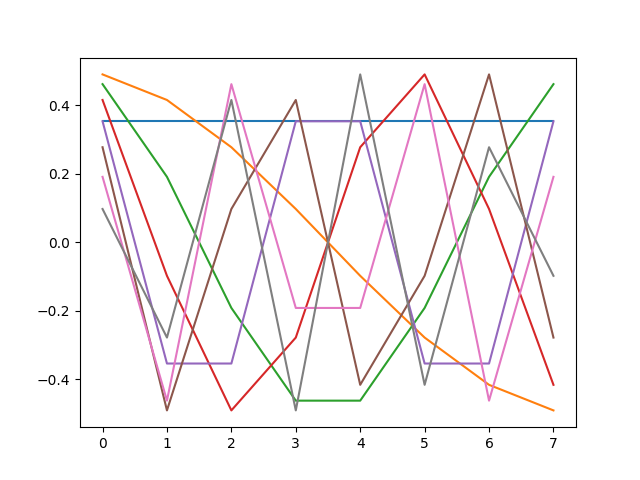

In [53]:
fig, ax = plt.subplots()
ax.plot(C8.T);


When we calculate the 1-D transform of an 8-point block of data, each
transform coefficient represents the component of the data that is
correlated with the corresponding row of `C8`.  Hence the
first coefficient represents the dc component, the second one
represents the approximate average slope, and so on. The later
coefficients represent progressively higher frequency components
in the data.

The function `colxfm(X, C8)` will perform a 1-D transform on
the columns of image `X` using `C8`. We can
therefore perform a 2-D transform on `X` by using `colxfm` twice, once with transpose operators, as follows:

In [54]:
from cued_sf2_lab.familiarisation import load_mat_img
from cued_sf2_lab.dct import colxfm

X_pre_zero_mean, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X_pre_zero_mean - 128.0

Y = colxfm(colxfm(X, C8).T, C8).T

In `Y`, each $8 \times 8$ block of pixels has been replaced by an
equivalent block of transform coefficients.  The coefficient in the top left
corner of each block represents the dc value of the block of pixels;
coefficients along the top row represent increasing horizontal frequency
components, and along the left column represent increasing vertical frequency
components.  Other coefficients represent various combinations of horizontal
and vertical frequencies, in proportion to their horizontal and vertical
distances from the top left corner.

If we try to display `Y` directly as an image, it is rather
confusing because the different frequency components of each block
are all present adjacent to each other.  

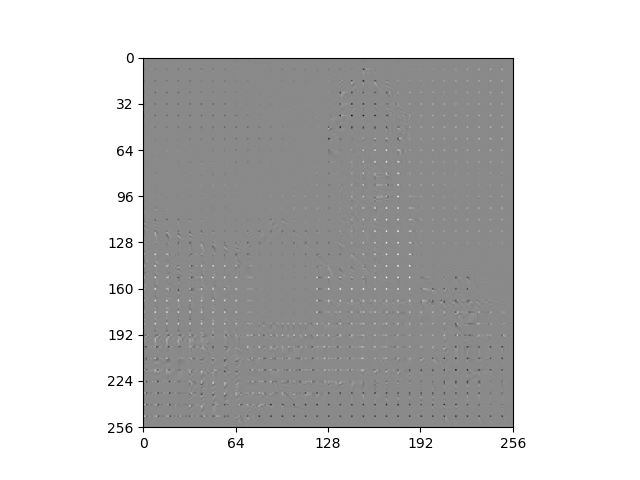

In [55]:
from cued_sf2_lab.familiarisation import plot_image

fig, ax = plt.subplots()
plot_image(Y, ax=ax);

A much more meaningful
image is created if we group all the coefficients of a given type
together into a small sub-image, and display the result as an $8
\times 8$ block of sub-images, one for each coefficient type.  The
function `regroup(Y, N)` achieves this regrouping, where $N$ is
the size of the original transform blocks. You need to ensure that X has zero mean (by subtracting 128) before you start transforming it, otherwise the dc coefficient will be purely positive, whereas the
others are symmetrically distributed about zero. Also, an $N
\times N$ 2-D DCT introduces a gain factor of $N$ in order to
preserve constant total energy between the pixel and transform
domains: we need to divide by $N$ *when displaying* to get back to the expected range.

Hence we can display `Y` meaningfully using:

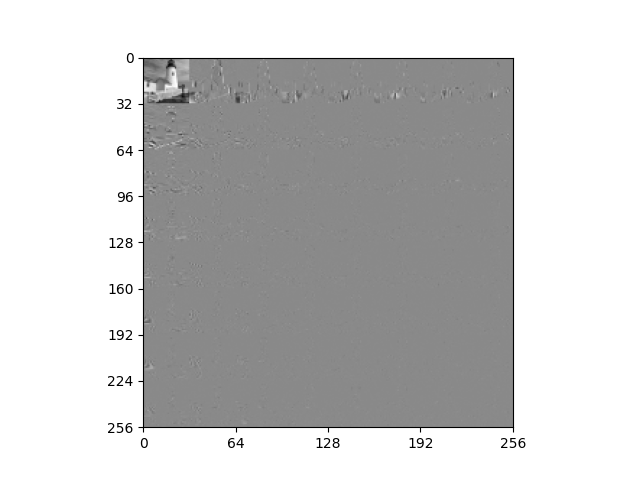

In [56]:
from cued_sf2_lab.dct import regroup

N = 8
fig, ax = plt.subplots()
plot_image(regroup(Y, N)/N, ax=ax);

In this image, you should see a small replica of the original in the top left
corner (the dc coefficients), and other sub-images showing various edges from
the original, representing progressively higher frequencies as you move
towards the lower right corner.

<div class="alert alert-block alert-danger">

What do you observe about the energies of the sub-images as frequencies
increase?</div>

In [57]:
# Your code here
print(Y.shape)

def compute_energy_sub_image(Y):
    """Compute the energies of the sub-images of Y as frequencies increase"""
    energies =[]
    block = Y.shape[0]
    for i in range(block):
        sub_image = Y[i, :]
        energy = np.sum(sub_image**2)
        energies.append(energy)

    return energies

energies = compute_energy_sub_image(Y)

for i in range(len(energies)):
    print(f'energy of sub-image{i} = {energies[i]}')

(256, 256)
energy of sub-image0 = 475046.1249999999
energy of sub-image1 = 55849.8619397633
energy of sub-image2 = 10840.259106878497
energy of sub-image3 = 2880.8572953279936
energy of sub-image4 = 2006.1249999999995
energy of sub-image5 = 958.2925224710784
energy of sub-image6 = 731.9908931215027
energy of sub-image7 = 623.4882424376024
energy of sub-image8 = 1047802.2499999998
energy of sub-image9 = 38942.0316809684
energy of sub-image10 = 49124.53384325465
energy of sub-image11 = 9806.214661313099
energy of sub-image12 = 2544.2499999999964
energy of sub-image13 = 1975.475616763753
energy of sub-image14 = 1169.9661567453845
energy of sub-image15 = 1019.2780409547443
energy of sub-image16 = 1903117.2499999998
energy of sub-image17 = 377350.5382841676
energy of sub-image18 = 172520.2978373077
energy of sub-image19 = 44306.478868065504
energy of sub-image20 = 22009.749999999996
energy of sub-image21 = 20430.203465197814
energy of sub-image22 = 22841.702162692185
energy of sub-image23 =

Now check that you can recover the original image from Y
by carrying out the inverse transform using:

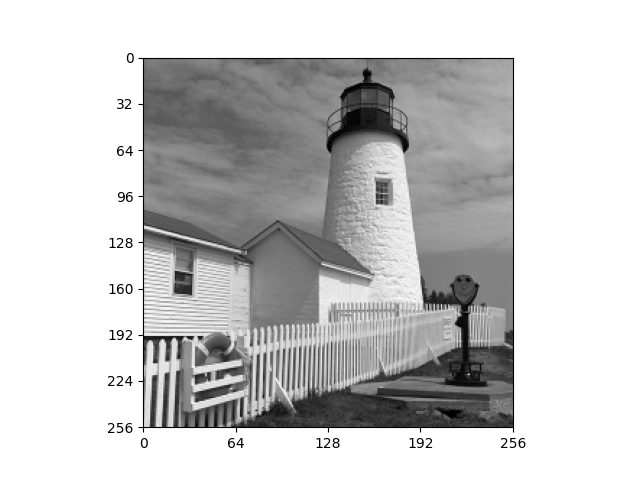

In [58]:
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax);

**Measure the maximum absolute error between X and Z
to confirm this.**

In [59]:
# Your code here
diff = np.max(np.abs(X-Z))
print(diff)

6.110667527536862e-13


The DCT analyses each $8 \times 8$ block of image pixels into a linear
combination of sixty-four $8 \times 8$ basis functions.  The following will generate
an image comprising these basis functions (the `np.nan`s separate the sub-images as matplotlib draws them as transparent, and the `reshape` function converts from a matrix to a row vector):

/tmp/ipykernel_5458/1006463478.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


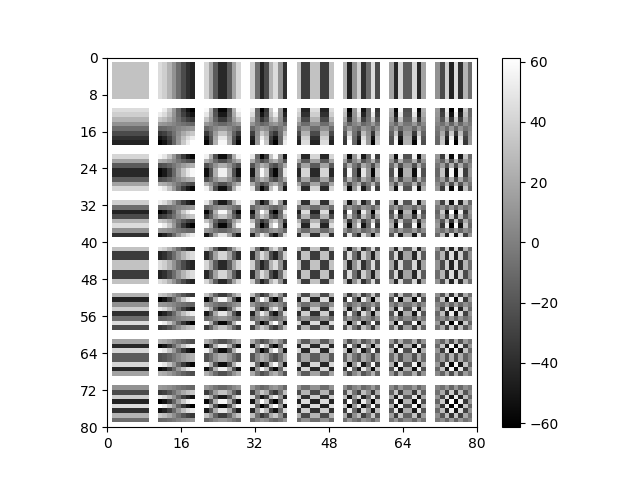

In [60]:
import numpy as np
# Stack some NaNs
bases = np.concatenate([np.full((8, 1), np.nan), C8, np.full((8, 1), np.nan)], axis=1)
# Reshape
bases_flat = np.reshape(bases, (-1, 1))

fig, ax = plt.subplots()
im = plot_image(255*bases_flat@bases_flat.T, ax=ax)
fig.colorbar(im);

<div class="alert alert-block alert-danger">

Explain how this image relates to the DCT coefficients.</div>

**The generated image comprising the DCT basis functions represents the spatial patterns that the DCT coefficients capture in an image. Each $8 \times 8$ basis function corresponds to a specific frequency component in the image. The image is constructed by taking the outer product of each basis function with itself (transposed), resulting in a matrix that represents the correlation between different basis functions.

By visualizing this correlation matrix, we can observe the patterns and relationships between the basis functions. The diagonal elements represent the self-correlation of each basis function, showing how much energy is concentrated in each frequency component. Off-diagonal elements represent the correlations between different frequency components.

The colorbar associated with the image indicates the intensity or magnitude of the correlation. Darker regions indicate higher correlation or stronger presence of certain frequency components in the image. Lighter regions indicate lower correlation or absence of certain frequency components.

Overall, this image helps us understand the basis functions and their relationships, providing insight into how the DCT coefficients capture different frequencies and spatial patterns in the image.**

## 7.3 Quantisation and Coding Efficiency

We are now going to look at the effects of quantising the DCT coefficients
fairly coarsely and determine the entropies of the coefficient sub-images.
At this stage we shall quantise all sub-images with the same step-size,
since they all are the same size and have unit energy gain from the
quantiser to the output image (due to the orthonormal transform matrices).

First quantise the transformed image Y using a step size
of 17 to give Yq.  Then regroup Yq to form
sub-images of each coefficient type as before, to give Yr. These sub-images have different probability distributions and we can take advantage of this later in coding them efficiently. Hence we get a better estimate of the number of bits required to code Yq by looking at the entropies of each of the re-grouped sub-images separately.

**Write a function `dctbpp(Yr, N)` to calculate the total number of bits from a re-grouped image Yr, by using `bpp(Ys)` on each sub-image Ys of Yr, then multiplying each result by the number of pixels in the sub-image, and summing to give the total number of bits.**

In [61]:
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.laplacian_pyramid import quantise

def dctbpp(Yr, N):
    # Your code here
    # Ys = sub-image of Yr
    sub = Yr.reshape(N, 256//N, N, 256//N).swapaxes(2, 1)
    num_bit = 0
    for i in range(sub.shape[0]):
        for j in range(sub.shape[1]):
            Ys = sub[i][j]
            num_bit += bpp(Ys)*Ys.size
    return num_bit

<div class="alert alert-block alert-danger">

Visualise Yr and comment on the distributions in each of the sub-images. Use the function `dctbpp(Yr, N)` that you have written to calculate the total number of bits, and compare it with just using `bpp(Yr)`, explaining your results.

</div>

In [62]:
step = 17
Yq = quantise(Y, step)
Yr = regroup(Yq, N)/N
print(Yr[0, 0])

-10.625


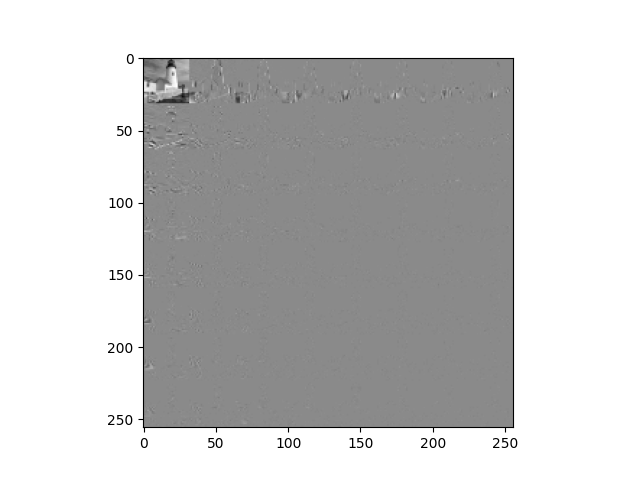

In [63]:
# Your code here
# viualise Yr
fig, ax = plt.subplots()
ax.imshow(Yr, cmap='gray')
plt.show()

**Sub-image at top left: corresponds to the DC component of the image. represents the overall average intensity of the image and tends to have a relatively flat distribution with a concentrated value.

Sub-images along the top row: represent the horizontal frequency components of the image. the freq increases, as we move from left to right. The distributions in these sub-images capture the variations and edges in the horizontal direction.

Sub-images along the left column: represent the vertical frequency components of the image. As we move downwards, the frequency increases. The distributions in these sub-images capture the variations and edges in the vertical direction.

Other sub-images: These represent the higher frequency components in both horizontal and vertical directions. They capture more detailed variations and textures present in the image.**

In [64]:
# calculate the total num of bits
total_bits = dctbpp(Yr, N)
print(f'Total number of bits = {total_bits}')
print(f'simply using bpp = {bpp(Yr)*Yr.size}')
print(f'differece = {bpp(Yr)*Yr.size - total_bits}')

Total number of bits = 97467.19741586194
simply using bpp = 109626.49318603268
differece = 12159.295770170735


<div class="alert alert-block alert-danger">

Now reconstruct the output image `Z` from `Yq` and measure the rms
error (standard deviation) between `X` and `Z`.  Compare this with the
error produced by quantising `X` with a step-size of 17 to give `Xq`.

</div>

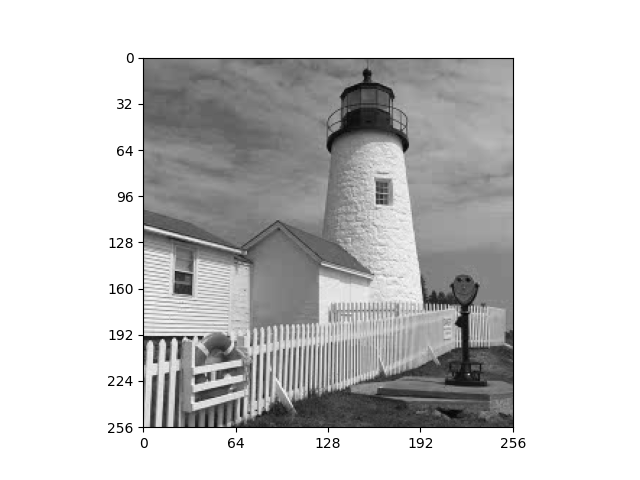

Bad pipe message: %s [b'\xc7\x8413\xd0=:\xa7\xdf\x97r\xd5\xdbB4l\x89U \x99\xbb.\x13\xee\x9c\x96\x13\x05Y\x0b\xc4\xb5I\xf0.\xeb\xa0b\xa6\xef\xf6\xa4/n\x91R\xe6pm\x02\xc8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00']
Bad pipe message: %s [b'\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xe0\xe3\xafj\xed\xbepy\x95\x1e\x92K:*\xd3\r\xe1\x12\x7f\xceP\xfa\\\x89\x8a\xed\xe8\xc8\x80\xf9\xde#']
Bad pipe message: %s [b'\x83\xef[\xe7G\x87\xf6\x95z\x1e\xc3\x16}Y\xb5r\xbc\xed \xcf\xd7\x1ar\xd9\xb6%\xab\xb5\xbf]\xaaFt9\x00\xa3\xc3\x88\xc0Hu\x9cg\xcbq\xd1#:0\xbcS\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x

In [65]:
# Your code here

Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax)
plt.show()

In [66]:
# Calculate RMS error between X and Z
rms_error_Z = np.std(X - Z)

# Quantize X with step-size of 17
Xq = quantise(X, step)
rms_error_Xq = np.std(X - Xq)

print(f'rms error between X and Z = {rms_error_Z}')
print(f'rms error between X and Xq = {rms_error_Xq}')

rms error between X and Z = 3.756757368843634
rms error between X and Xq = 4.861168497356846


***As with the Laplacian Pyramid, we really need to contrast compression ratios and visual results on compressed images with the same rms error. Re-use your step optimisation code to calculate the (non-integer) step size required in this case for the same rms error as quantising X with a step-size of 17.***

In [67]:
# Your code here
initial = 1
step_size = initial
error = {}
direct = np.std(X - Xq)
for i in range(256):
    Yq = quantise(Y, step_size)
    Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    rms_error_Z = np.std(X - Z)
    #print(direct, rms_error_Z, step_size)
    error[step_size] = abs(rms_error_Z - direct)
    step_size *= np.sqrt(direct / rms_error_Z)  # update step size based on error difference

opt_step = min(error, key=error.get)
print(f'optimal non-integer step size = {opt_step}')
print(error[opt_step])


optimal non-integer step size = 23.691138779586236
8.881784197001252e-16


In [68]:
def optimize_step_size_dct_(X, Y, C, end=1000, divi=10):
    direct = np.std(X - quantise(X, 17))
    error = []
    rms_list = []
       
    for i in np.arange(0, end)/divi:
        Yq = quantise(Y, i)
        Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
        rms_list.append(np.std(X - Z))
        error.append(abs(np.std(X - Z) - direct))

    index = np.argmin(error)
    opt = (index + 1)/divi
    return opt, error[index], rms_list[index]

In [69]:
opt8, error8, rms8 = optimize_step_size_dct_(X, Y, C8)
print(opt8, error8)

23.8 0.0012993812944896987


<div class="alert alert-block alert-danger">

Calculate the compression ratio for this scheme compared to direct quantisation. Use `dctbpp` to calculate the number of bits needed. Contrast the visual appearance of the DCT-compressed image, the directly quantised image, and the original image.

</div>

number of bits required for DCT-compressed = 77275.11247642421
number of bits required for directly quantised = 228119.03651868744
compression ratio for opt scheme = 2.952037586335239
compression ratio for directly quantised = 1.0


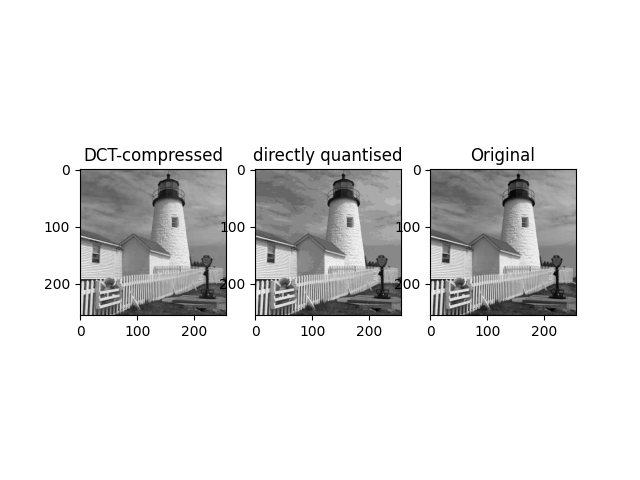

In [70]:
# Your code here
N = 8
Yq_opt8 = quantise(Y, opt8)
Yr_opt8 = regroup(Yq_opt8, N)/N
Z_opt8 = colxfm(colxfm(Yq_opt8.T, C8.T).T, C8.T)
num_bits_dct8 = dctbpp(Yr_opt8, N)
num_bits_direct = bpp(Xq) * Xq.size
num_bits_X = bpp(quantise(X, 17))*X.size

compression_ratio_dct8 = num_bits_X/num_bits_dct8
compression_ratio_direct = num_bits_X/num_bits_direct
print(f'number of bits required for DCT-compressed = {num_bits_dct8}')
print(f'number of bits required for directly quantised = {num_bits_direct}')
print(f'compression ratio for opt scheme = {compression_ratio_dct8}')
print(f'compression ratio for directly quantised = {compression_ratio_direct}')

fig, ax = plt.subplots(1, 3)
ax[0].imshow(Z_opt8, cmap='gray')
ax[0].set_title('DCT-compressed')
ax[1].imshow(Xq, cmap='gray')
ax[1].set_title('directly quantised')
ax[2].imshow(X, cmap='gray')
ax[2].set_title('Original')
plt.show()



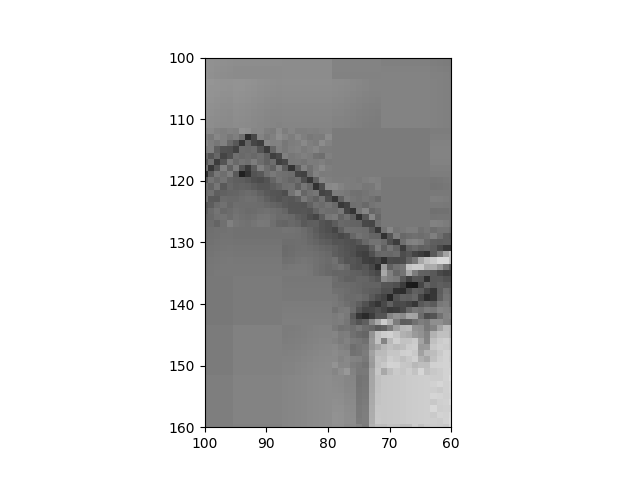

In [71]:
fig, ax = plt.subplots()
ax.imshow(Z_opt8, cmap='gray')
ax.set_xlim(100, 60)
ax.set_ylim(160, 100)
plt.show()


## 7.4 Alternative transform sizes

So far, we have concentrated on $8 \times 8$ DCTs using C8
as the 1-D transform matrix.  **Now generate 4-point and 16-point
transform matrices, C4 and C16 using `dct_ii`.**


In [72]:
# Your code here
C4 = dct_ii(4)
C16 = dct_ii(16)
Y4 = colxfm(colxfm(X, C4).T, C4).T
Y16 = colxfm(colxfm(X, C16).T, C16).T

<div class="alert alert-block alert-danger">

Repeat the main measurements from the previous section, so as to obtain
estimates of the number of bits and compression ratios for $4 \times 4$ and $16 \times 16$ DCTs when the
rms errors are equivalent to those in your previous tests.  Also assess the
relative subjective quality of the reconstructed images.</div>

In [77]:
opt4, error4, rms4 = optimize_step_size_dct_(X, Y4, C4)
print(opt4)
print(error4)

24.0
7.324136770581191e-05


optimal non-integer step size = 24.0
7.324136770581191e-05
number of bits required for DCT-compressed = 85930.17210358605
number of bits required for directly quantised = 228119.03651868744
compression ratio for opt scheme = 2.654702427963222
compression ratio for directly quantised = 1.0


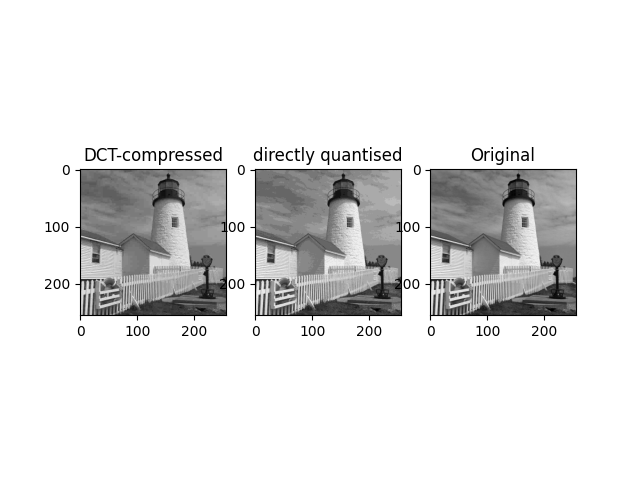

In [79]:
# Your code here
# For 4x4 DCTs
N = 4

print(f'optimal non-integer step size = {opt4}')
print(error4)

# compare visual quality
Yq_opt4 = quantise(Y4, opt4)
Yr_opt4 = regroup(Yq_opt4, N)/N
Z_opt4 = colxfm(colxfm(Yq_opt4.T, C4.T).T, C4.T)
num_bits_dct4 = dctbpp(Yr_opt4, N)
num_bits_direct = bpp(Xq) * Xq.size
num_bits_X = bpp(quantise(X, 17))*X.size

compression_ratio_dct4 = num_bits_X/num_bits_dct4
compression_ratio_direct = num_bits_X/num_bits_direct
print(f'number of bits required for DCT-compressed = {num_bits_dct4}')
print(f'number of bits required for directly quantised = {num_bits_direct}')
print(f'compression ratio for opt scheme = {compression_ratio_dct4}')
print(f'compression ratio for directly quantised = {compression_ratio_direct}')

fig, ax = plt.subplots(1, 3)
ax[0].imshow(Z_opt4, cmap='gray')
ax[0].set_title('DCT-compressed')
ax[1].imshow(Xq, cmap='gray')
ax[1].set_title('directly quantised')
ax[2].imshow(X, cmap='gray')
ax[2].set_title('Original')
plt.show()

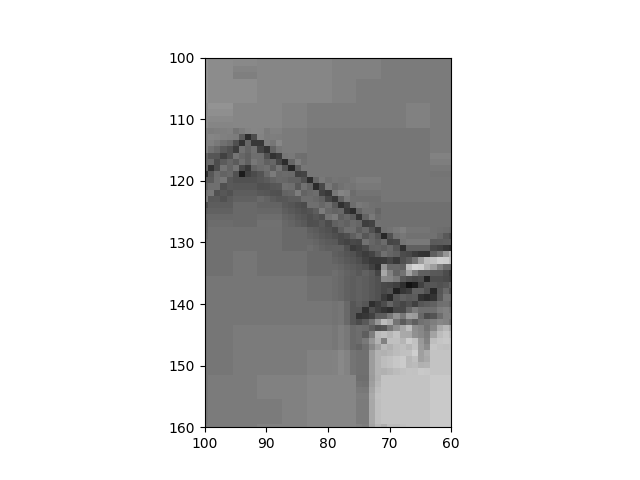

In [ ]:
fig, ax = plt.subplots()
ax.imshow(Z_opt4, cmap='gray')
ax.set_xlim(100, 60)
ax.set_ylim(160, 100)
plt.show()

In [75]:
opt16, error16, rms16 = optimize_step_size_dct_(X, Y16, C16)
print(opt16)
print(error16)

22.4
0.006067995365716783


optimal non-integer step size = 22.4
0.006067995365716783
number of bits required for DCT-compressed = 79011.33517822235
number of bits required for directly quantised = 228119.03651868744
compression ratio for opt scheme = 2.8871684803722086
compression ratio for directly quantised = 1.0


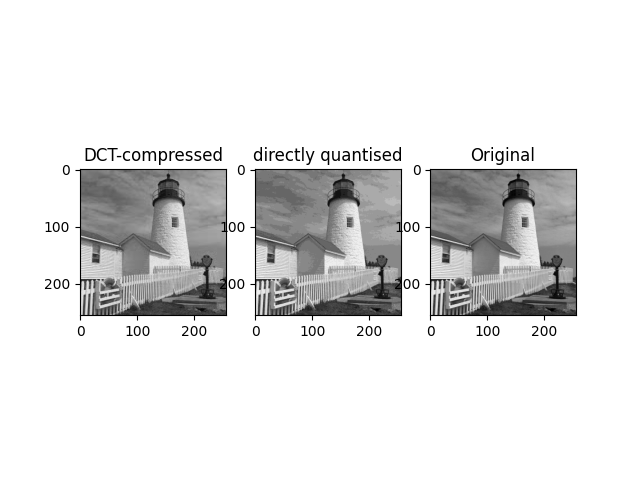

In [76]:
# For 16x16 DCTs
N = 16

print(f'optimal non-integer step size = {opt16}')
print(error16)

# compare visual quality
Yq_opt16 = quantise(Y16, opt16)
Yr_opt16 = regroup(Yq_opt16, N)/N
Z_opt16 = colxfm(colxfm(Yq_opt16.T, C16.T).T, C16.T)
num_bits_dct16 = dctbpp(Yr_opt16, N)
num_bits_direct = bpp(Xq) * Xq.size
num_bits_X = bpp(quantise(X, 17))*X.size

compression_ratio_dct16 = num_bits_X/num_bits_dct16
compression_ratio_direct = num_bits_X/num_bits_direct
print(f'number of bits required for DCT-compressed = {num_bits_dct16}')
print(f'number of bits required for directly quantised = {num_bits_direct}')
print(f'compression ratio for opt scheme = {compression_ratio_dct16}')
print(f'compression ratio for directly quantised = {compression_ratio_direct}')

fig, ax = plt.subplots(1, 3)
ax[0].imshow(Z_opt16, cmap='gray')
ax[0].set_title('DCT-compressed')
ax[1].imshow(Xq, cmap='gray')
ax[1].set_title('directly quantised')
ax[2].imshow(X, cmap='gray')
ax[2].set_title('Original')
plt.show()

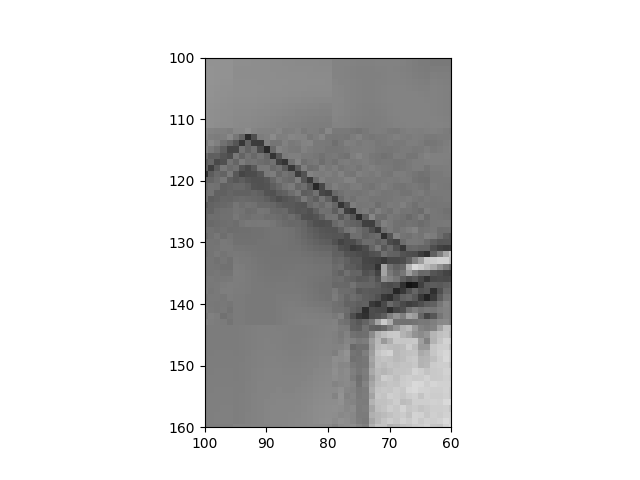

In [ ]:
fig, ax = plt.subplots()
ax.imshow(Z_opt16, cmap='gray')
ax.set_xlim(100, 60)
ax.set_ylim(160, 100)
plt.show()

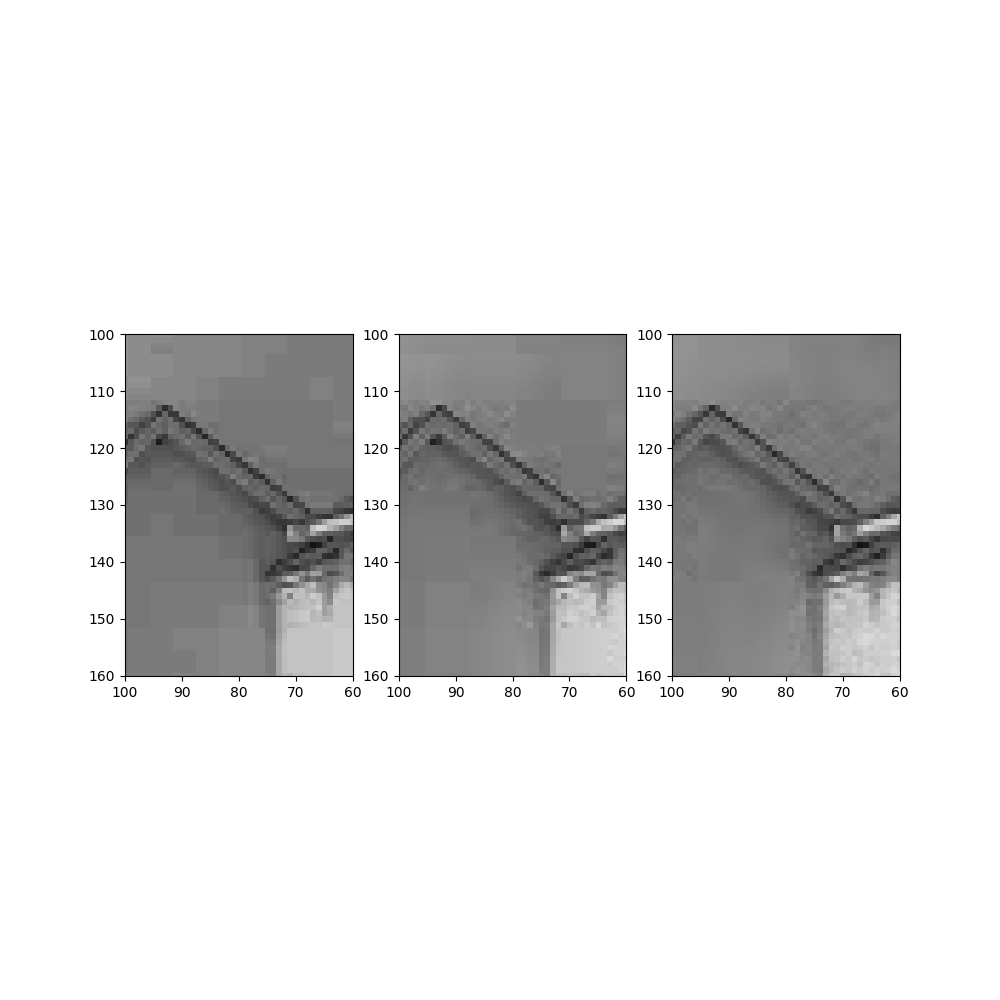

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(Z_opt4, cmap='gray')
ax[0].set_xlim(100, 60)
ax[0].set_ylim(160, 100)
ax[1].imshow(Z_opt8, cmap='gray')
ax[1].set_xlim(100, 60)
ax[1].set_ylim(160, 100)
ax[2].imshow(Z_opt16, cmap='gray')
ax[2].set_xlim(100, 60)
ax[2].set_ylim(160, 100)
#plt.savefig('6_schemes.png', dpi=300, bbox_inches='tight')
plt.show()


This analysis is in fact slightly biased because with larger transform sizes the function `dctbpp(Yr, N)` will use a greater number of smaller sub-images on which to calculate probability distributions. It may be better to use the same N in this function even when the actual transform changes; however whether this is more predictive of actual coding performance depends on what scanning method is used in the coding scheme.

<div class="alert alert-block alert-danger">

What happens in the limit if you use `dctbpp(Yr, 256)` (i.e. the entropy is calculated independently for each pixel)? Why is this the case, and why isn't this a realistic result?</div>

**Regarding the use of dctbpp(Yr, 256), when the entropy is calculated independently for each pixel, it means that each pixel is treated as a separate sub-image. This approach assumes that there is no correlation or structure among the neighboring pixels within each sub-image. In reality, images typically exhibit spatial correlation, and the DCT coefficients capture this correlation by grouping the pixels into larger sub-images. By using dctbpp(Yr, 256), we ignore this correlation and overestimate the entropy, resulting in an unrealistic and inflated estimate of the number of bits required. Therefore, it is not a realistic result for practical image coding scenarios.**

In [ ]:
# Your code here
N = 256
C256 = dct_ii(256)
Y256 = colxfm(colxfm(X, C256).T, C256).T
opt256, error256, rms256 = optimize_step_size_dct_(X, Y256, C256)
Yq_opt256 = quantise(Y256, opt256)
Yr_opt256 = regroup(Yq_opt256, N)/N
Z_opt16 = colxfm(colxfm(Yq_opt256.T, C256.T).T, C256.T)

In [ ]:
num_bits_dct256 = dctbpp(Yr_opt256, N)
print(num_bits_dct256)

51058.270458369945


<div class="alert alert-block alert-danger">

Can you draw any conclusions about the best choice of transform size for the
Lighthouse image?  Try to postulate what features in other images might make your
conclusions different, and suggest why.</div>

**Based on the measurements and observations made for the Lighthouse image, we can draw some conclusions about the choice of transform size:

1. **Compression Ratio:** The $8 \times 8$ DCT achieved a higher compression ratio compared to the $4 \times 4$ and $16 \times 16$ DCTs while maintaining a similar RMS error. This suggests that for the Lighthouse image, the $8 \times 8$ DCT provides a good balance between compression efficiency and image quality.

2. **Visual Quality:** The reconstructed image using the $8 \times 8$ DCT exhibited better subjective visual quality compared to the $4 \times 4$ and $16 \times 16$ DCTs. The $4 \times 4$ DCT resulted in blocky artifacts due to its limited representation capacity, while the $16 \times 16$ DCT might have lost some fine details due to its coarser frequency resolution.

These conclusions can be influenced by the characteristics of the specific image. Different images with varying characteristics might lead to different conclusions. Some factors that can affect the choice of transform size and its impact are:

1. **Image Content:** Images with complex and detailed textures or fine structures might benefit from a larger transform size (e.g., $16 \times 16$ or higher) to capture and represent the finer details accurately. On the other hand, images with smoother regions or fewer details might be adequately represented using a smaller transform size (e.g., $4 \times 4$ or $8 \times 8$).

2. **Blockiness and Artifacts:** Larger transform sizes can introduce more visible blockiness artifacts in regions with sharp transitions or edges. If an image contains such regions, smaller transform sizes may be preferred to mitigate these artifacts.

3. **Computational Complexity:** Larger transform sizes require more computational resources and time for encoding and decoding. For real-time applications or systems with limited processing power, a smaller transform size can be more practical.

4. **Application Requirements:** The choice of transform size can also depend on specific application requirements. For example, in image compression for transmission over low-bandwidth networks, a smaller transform size may be preferred to reduce the data size and improve transmission speed.

Overall, the choice of transform size should consider a trade-off between compression efficiency, visual quality, computational complexity, and the characteristics of the image and application. Experimentation and analysis of different transform sizes on representative images can provide insights into the best choice for a particular scenario.**

In [ ]:
# Your code here

In [ ]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
Xq = np.std(X - quantise(X, 17))
num_bits_direct = bpp(Xq) * Xq.size
print(num_bits_direct)

-0.0


In [ ]:
print(direct)

4.861168497356846
